<a href="https://colab.research.google.com/github/lintaoye1388/NN-NPC/blob/main/retina_MINST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.10MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 9.54MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 2.40MB/s]


Training started...
Epoch 1/5 complete.
Epoch 2/5 complete.
Epoch 3/5 complete.
Epoch 4/5 complete.
Epoch 5/5 complete.

Visualizing Learned Weights...


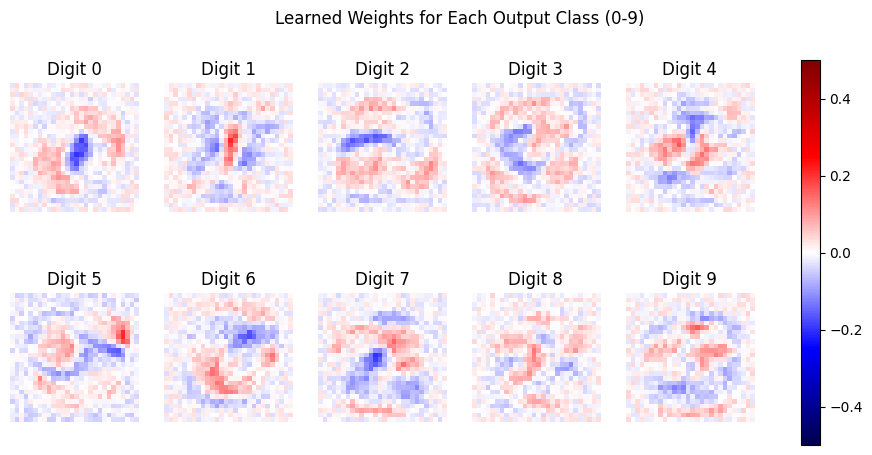

Model saved as 'mnist_simple_model.pth'


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
BATCH_SIZE = 64
EPOCHS = 5
LEARNING_RATE = 0.01

# --- Data Preparation ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Standard MNIST normalization
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)

# --- Model Definition (No Hidden Layer) ---
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        # Input: 28*28 = 784, Output: 10 classes
        self.fc = nn.Linear(784, 10)

    def forward(self, x):
        x = x.view(-1, 784) # Flatten
        x = self.fc(x)
        return x

model = SimpleNet()
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

# --- Training Loop ---
print("Training started...")
for epoch in range(EPOCHS):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{EPOCHS} complete.")

# --- Task 1 Visualization: Weight Mapping ---
print("\nVisualizing Learned Weights...")
weights = model.fc.weight.data.numpy() # Shape: (10, 784)

fig, axes = plt.subplots(2, 5, figsize=(12, 5))
fig.suptitle("Learned Weights for Each Output Class (0-9)")

for i, ax in enumerate(axes.flat):
    # Reshape the 784 vector back to 28x28 image
    weight_img = weights[i].reshape(28, 28)

    # Plotting
    im = ax.imshow(weight_img, cmap='seismic', vmin=-0.5, vmax=0.5)
    ax.set_title(f"Digit {i}")
    ax.axis('off')

plt.colorbar(im, ax=axes.ravel().tolist())
plt.show()

# Save model for Task 2
torch.save(model.state_dict(), "mnist_simple_model.pth")
print("Model saved as 'mnist_simple_model.pth'")

# Inference with mask

Model loaded successfully.
Running evaluation on 10000 images...
------------------------------
Method 1 Accuracy (Original):             91.91%
Method 2 Accuracy (Brightness x0.4):     75.05%
Method 3 Accuracy (Masked Weights):       77.23%
------------------------------


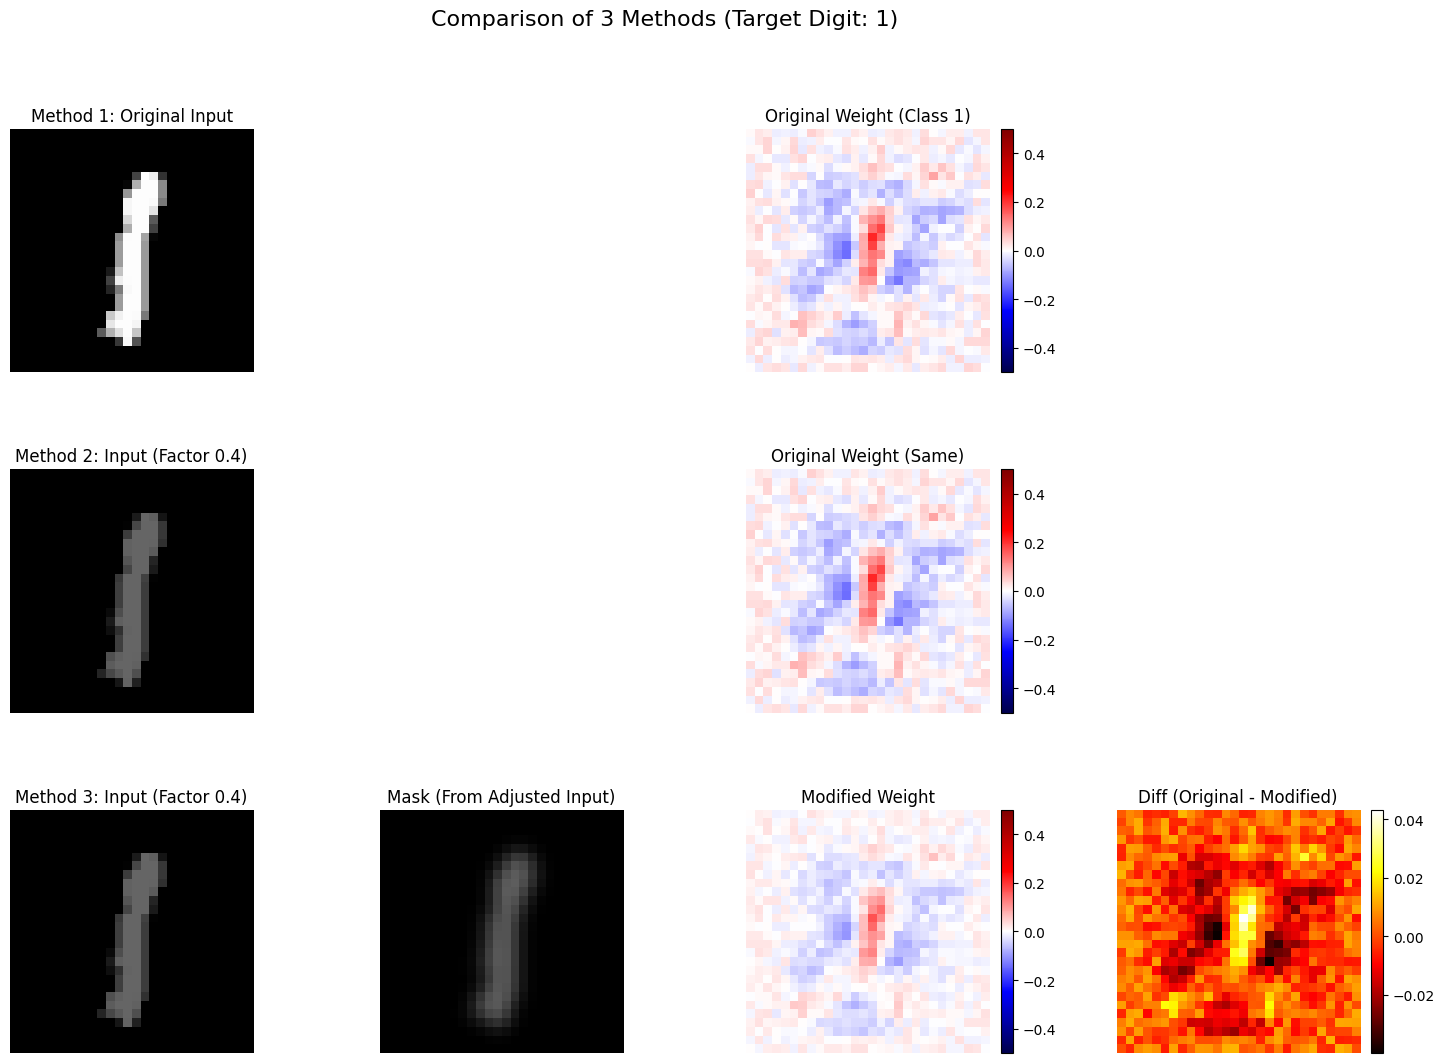

In [9]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

# --- User Adjustments ---
BRIGHTNESS_FACTOR = 0.4  # < 1.0 = Darker, > 1.0 = Lighter
BLUR_SIGMA = 1.0         # Extent of blur for the mask

# --- Constants ---
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

# --- Model Structure ---
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(784, 10)
    def forward(self, x):
        return self.fc(x.view(-1, 784))

# --- Data Loading ---
# Load raw [0, 1] data (No normalization yet) to allow easy brightness edits
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# --- Load Model ---
model = SimpleNet()
try:
    model.load_state_dict(torch.load("mnist_simple_model.pth"))
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Error: 'mnist_simple_model.pth' not found. Please run Task 1 first.")

model.eval()
weights_original = model.fc.weight.data.clone()
bias_original = model.fc.bias.data.clone()

# --- Helper Functions ---

def normalize_for_model(img_tensor):
    """Normalize [0,1] data to the range the model expects."""
    return (img_tensor - MNIST_MEAN) / MNIST_STD

def create_mask(img_tensor, sigma):
    """Create a blurred mask from the image (values 0 to 1)."""
    img_np = img_tensor.squeeze().numpy()
    blurred = scipy.ndimage.gaussian_filter(img_np, sigma=sigma)
    return np.clip(blurred, 0, 1)

def get_modified_weights(original_weights, mask):
    """
    Modify weights based on mask brightness.
    Mask 1.0 (White) -> Weight * 1.0
    Mask 0.0 (Black) -> Weight * 0.5
    """
    mask_flat = mask.flatten()
    # mask_factor = 0.5 + (0.5 * mask_flat) # Linear scale: 0.5 to 1.0
    mask_factor = 0.7 + (0.3 * mask_flat)
    mask_factor_tensor = torch.from_numpy(mask_factor).float()
    new_weights = original_weights * mask_factor_tensor
    return new_weights

# --- Evaluation Loop ---
correct_1, correct_2, correct_3 = 0, 0, 0
total = 0
sample_data = {}

print(f"Running evaluation on {len(test_loader)} images...")

with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        target = target.item()

        # --- Method 1: Original Data ---
        input1 = normalize_for_model(data)
        out1 = model(input1)
        if out1.argmax(dim=1).item() == target: correct_1 += 1

        # --- Method 2: Adjusted Brightness ---
        # Modify raw brightness, clamp to valid range, then normalize
        data_adj = torch.clamp(data * BRIGHTNESS_FACTOR, 0.0, 1.0)
        input2 = normalize_for_model(data_adj)
        out2 = model(input2)
        if out2.argmax(dim=1).item() == target: correct_2 += 1

        # --- Method 3: Adjusted + Masked Weights ---
        # Mask comes from the adjusted image
        mask_np = create_mask(data_adj, BLUR_SIGMA)
        w_mod = get_modified_weights(weights_original, mask_np)

        # Manual inference: y = xW^T + b
        x_flat = input2.view(-1, 784)
        out3 = torch.matmul(x_flat, w_mod.t()) + bias_original

        if out3.argmax(dim=1).item() == target: correct_3 += 1

        # Capture first sample for visualization
        if i == 0:
            sample_data = {
                'input_orig': data.squeeze().numpy(),
                'input_adj': data_adj.squeeze().numpy(),
                'mask': mask_np,
                'w_orig': weights_original[target].reshape(28,28).numpy(),
                'w_mod': w_mod[target].reshape(28,28).numpy(),
                'target': target
            }
        total += 1

# --- Results ---
acc1 = 100. * correct_1 / total
acc2 = 100. * correct_2 / total
acc3 = 100. * correct_3 / total

print("-" * 30)
print(f"Method 1 Accuracy (Original):             {acc1:.2f}%")
print(f"Method 2 Accuracy (Brightness x{BRIGHTNESS_FACTOR}):     {acc2:.2f}%")
print(f"Method 3 Accuracy (Masked Weights):       {acc3:.2f}%")
print("-" * 30)

# --- Visualization ---
fig, axes = plt.subplots(3, 4, figsize=(18, 12))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Row 1: Method 1
axes[0,0].imshow(sample_data['input_orig'], cmap='gray', vmin=0, vmax=1)
axes[0,0].set_title("Method 1: Original Input")
axes[0,1].axis('off')

im1 = axes[0,2].imshow(sample_data['w_orig'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[0,2].set_title(f"Original Weight (Class {sample_data['target']})")
fig.colorbar(im1, ax=axes[0,2], fraction=0.046, pad=0.04)
axes[0,3].axis('off')

# Row 2: Method 2
axes[1,0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
axes[1,0].set_title(f"Method 2: Input (Factor {BRIGHTNESS_FACTOR})")
axes[1,1].axis('off')

im2 = axes[1,2].imshow(sample_data['w_orig'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[1,2].set_title(f"Original Weight (Same)")
fig.colorbar(im2, ax=axes[1,2], fraction=0.046, pad=0.04)
axes[1,3].axis('off')

# Row 3: Method 3
axes[2,0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
axes[2,0].set_title(f"Method 3: Input (Factor {BRIGHTNESS_FACTOR})")

axes[2,1].imshow(sample_data['mask'], cmap='gray', vmin=0, vmax=1)
axes[2,1].set_title(f"Mask (From Adjusted Input)")

im3 = axes[2,2].imshow(sample_data['w_mod'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[2,2].set_title(f"Modified Weight")
fig.colorbar(im3, ax=axes[2,2], fraction=0.046, pad=0.04)

# Weight Difference
diff = sample_data['w_orig'] - sample_data['w_mod']
im_diff = axes[2,3].imshow(diff, cmap='hot')
axes[2,3].set_title("Diff (Original - Modified)")
fig.colorbar(im_diff, ax=axes[2,3], fraction=0.046, pad=0.04)

for ax in axes.flat:
    ax.axis('off')

plt.suptitle(f"Comparison of 3 Methods (Target Digit: {sample_data['target']})", fontsize=16)
plt.show()

# Visualize input images with brightness adjustment

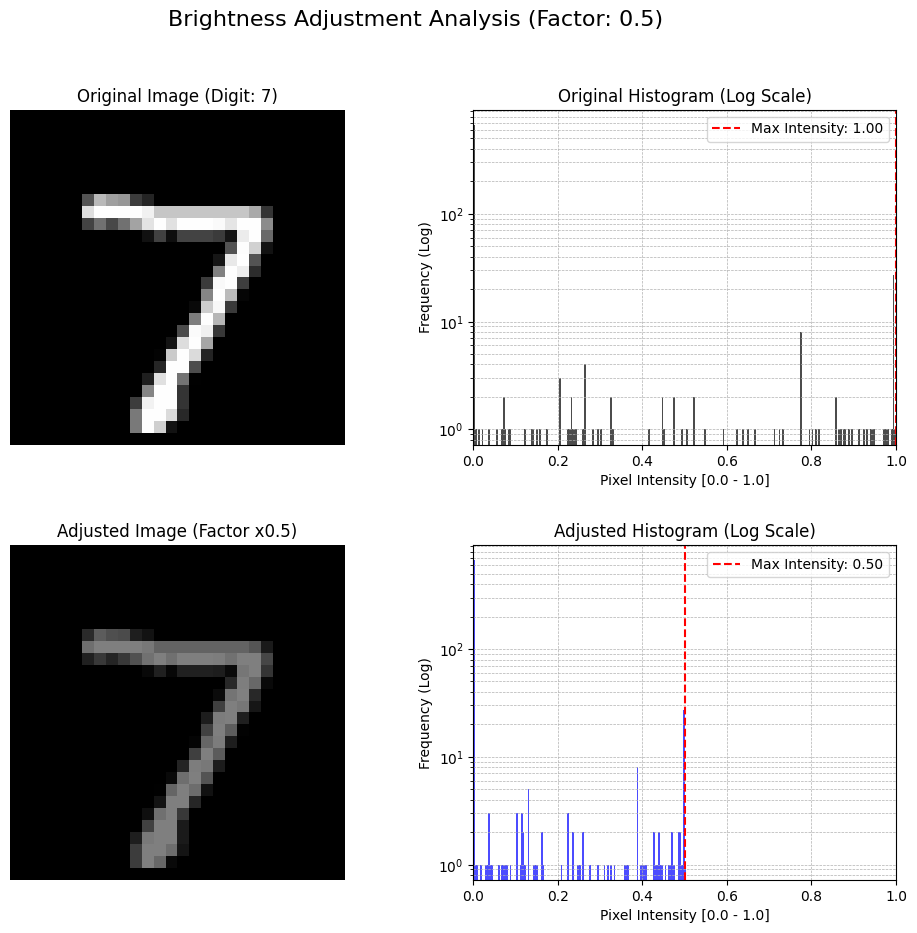

In [4]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# --- Configuration ---
# Change this value to adjust brightness.
# < 1.0 makes it darker, > 1.0 makes it lighter.
BRIGHTNESS_FACTOR = 0.5

# --- Data Loading (No Normalization for easier visualization) ---
# We only use ToTensor here to keep data in the [0.0, 1.0] range
transform_simple = transforms.Compose([
    transforms.ToTensor()
])

test_dataset_simple = datasets.MNIST('./data', train=False, download=True, transform=transform_simple)

# Pick a sample image (e.g., index 0 is usually a '7')
sample_idx = 0
original_tensor, label = test_dataset_simple[sample_idx]

# --- Apply Brightness Adjustment ---
# Simple linear multiplication
adjusted_tensor = original_tensor * BRIGHTNESS_FACTOR

# Important: Clamp values to ensure they stay within valid image range [0.0, 1.0]
# If factor > 1, pixels could exceed 1.0 without clamping.
adjusted_tensor = torch.clamp(adjusted_tensor, 0.0, 1.0)

# --- Prepare for Plotting ---
# Convert tensors to numpy 2D arrays for imshow
orig_np = original_tensor.squeeze().numpy()
adj_np = adjusted_tensor.squeeze().numpy()

# Flatten arrays for histogram plotting
orig_flat = orig_np.flatten()
adj_flat = adj_np.flatten()

# --- Visualization ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
plt.subplots_adjust(hspace=0.3)
fig.suptitle(f"Brightness Adjustment Analysis (Factor: {BRIGHTNESS_FACTOR})", fontsize=16)

# 1. Original Image
axes[0, 0].imshow(orig_np, cmap='gray', vmin=0, vmax=1)
axes[0, 0].set_title(f"Original Image (Digit: {label})")
axes[0, 0].axis('off')

# 2. Original Histogram
# We use 'log=True' for the y-axis because the background black pixels count
# is vastly higher than the digit pixel counts, masking details.
axes[0, 1].hist(orig_flat, bins=256, range=(0, 1), color='black', alpha=0.7, log=True)
axes[0, 1].set_title("Original Histogram (Log Scale)")
axes[0, 1].set_xlabel("Pixel Intensity [0.0 - 1.0]")
axes[0, 1].set_ylabel("Frequency (Log)")
axes[0, 1].set_xlim(0, 1)
axes[0, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

# 3. Adjusted Image
axes[1, 0].imshow(adj_np, cmap='gray', vmin=0, vmax=1)
axes[1, 0].set_title(f"Adjusted Image (Factor x{BRIGHTNESS_FACTOR})")
axes[1, 0].axis('off')

# 4. Adjusted Histogram
axes[1, 1].hist(adj_flat, bins=256, range=(0, 1), color='blue', alpha=0.7, log=True)
axes[1, 1].set_title("Adjusted Histogram (Log Scale)")
axes[1, 1].set_xlabel("Pixel Intensity [0.0 - 1.0]")
axes[1, 1].set_ylabel("Frequency (Log)")
axes[1, 1].set_xlim(0, 1)
axes[1, 1].grid(True, which='both', linestyle='--', linewidth=0.5)

# Add vertical lines indicating the maximum pixel intensity in the digit
max_orig = np.max(orig_flat)
max_adj = np.max(adj_flat)
axes[0, 1].axvline(max_orig, color='r', linestyle='dashed', linewidth=1.5, label=f'Max Intensity: {max_orig:.2f}')
axes[1, 1].axvline(max_adj, color='r', linestyle='dashed', linewidth=1.5, label=f'Max Intensity: {max_adj:.2f}')
axes[0, 1].legend()
axes[1, 1].legend()

plt.show()

# 4 methods

Model loaded successfully.
Running evaluation on 10000 images...
--------------------------------------------------
Method 1 Accuracy (Original):             91.91%
Method 2 Accuracy (Brightness x0.4):     75.05%
Method 3 Accuracy (Masked Weights):       79.72%
Method 4 Accuracy (Strict Decrease):      64.48%
--------------------------------------------------


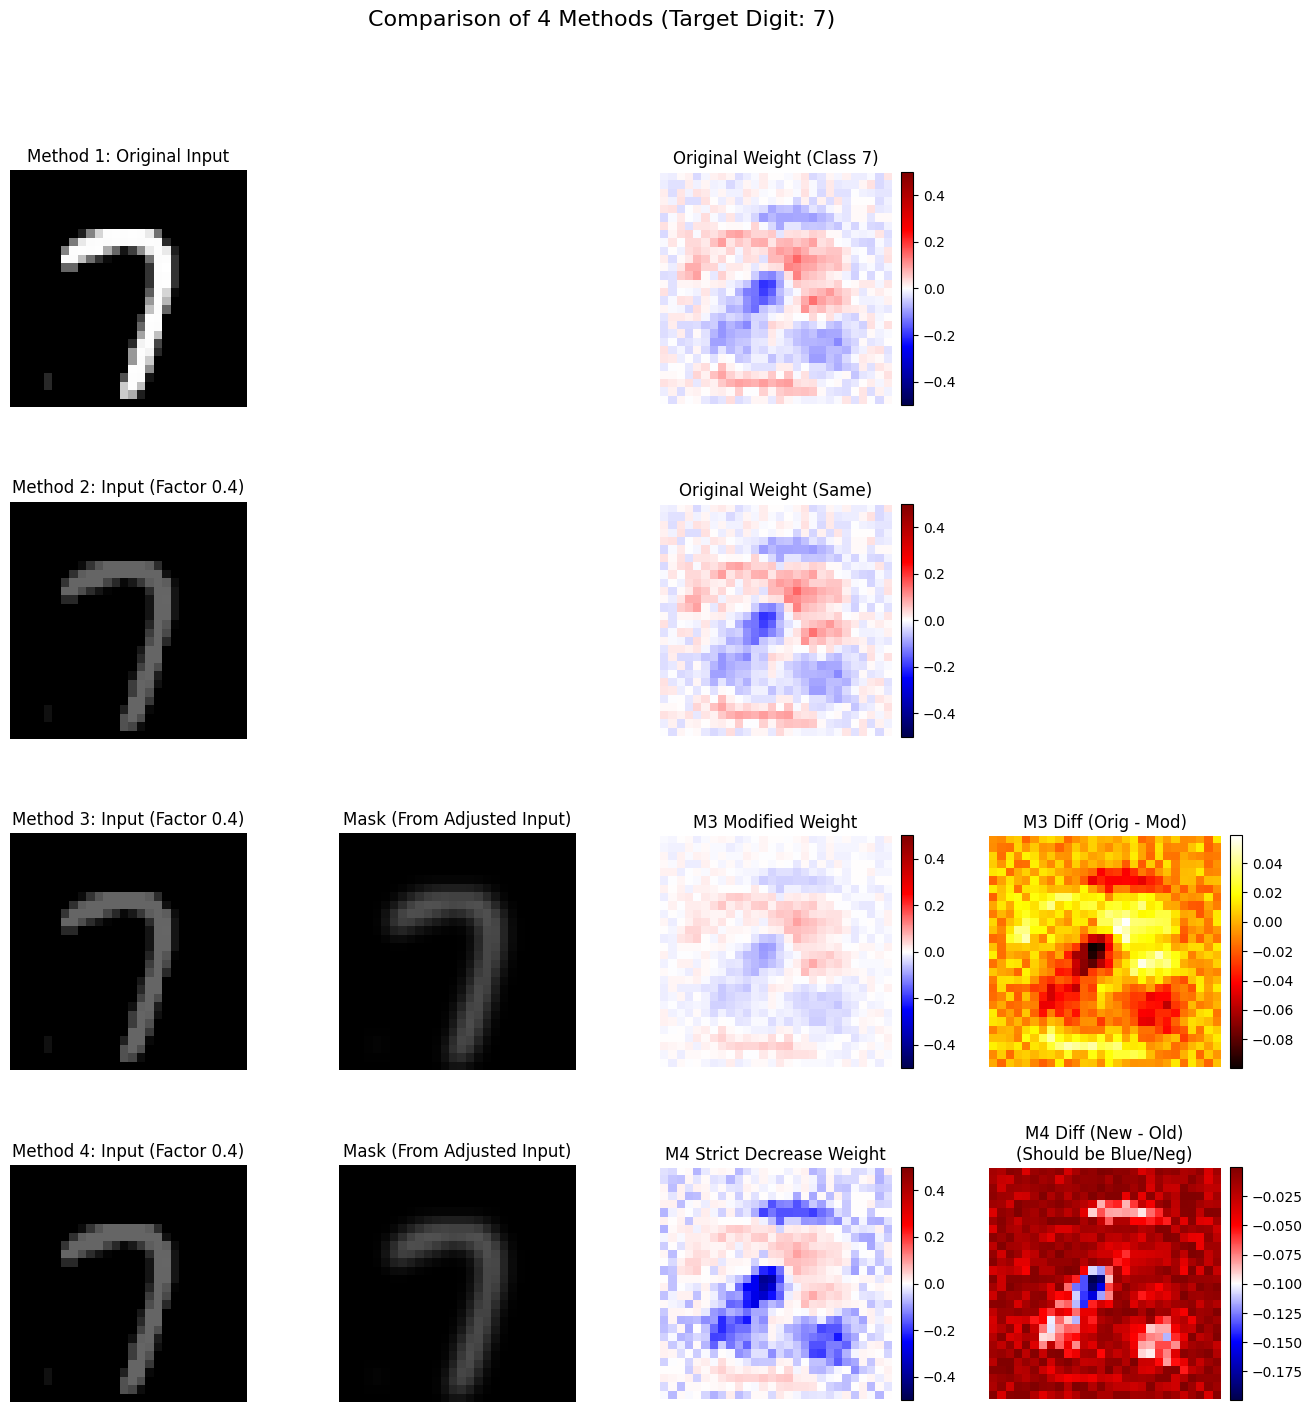

In [8]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

# --- User Adjustments ---
BRIGHTNESS_FACTOR = 0.4  # < 1.0 = Darker, > 1.0 = Lighter
BLUR_SIGMA = 1.0         # Extent of blur for the mask

# --- Constants ---
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

# --- Model Structure ---
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(784, 10)
    def forward(self, x):
        return self.fc(x.view(-1, 784))

# --- Data Loading ---
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# --- Load Model ---
model = SimpleNet()
try:
    model.load_state_dict(torch.load("mnist_simple_model.pth"))
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Error: 'mnist_simple_model.pth' not found. Please run Task 1 first.")

model.eval()
weights_original = model.fc.weight.data.clone()
bias_original = model.fc.bias.data.clone()

# --- Helper Functions ---

def normalize_for_model(img_tensor):
    return (img_tensor - MNIST_MEAN) / MNIST_STD

def create_mask(img_tensor, sigma):
    img_np = img_tensor.squeeze().numpy()
    blurred = scipy.ndimage.gaussian_filter(img_np, sigma=sigma)
    return np.clip(blurred, 0, 1)

def get_modified_weights(original_weights, mask):
    """Method 3: Standard Masking (Positive shrinks, Negative shrinks magnitude)."""
    mask_flat = mask.flatten()
    mask_factor = 0.5 + (0.5 * mask_flat)
    mask_factor_tensor = torch.from_numpy(mask_factor).float()
    return original_weights * mask_factor_tensor

def get_strictly_decreased_weights(original_weights, mask):
    """
    Method 4: Strict Decrease.
    - If Weight > 0: Multiply by factor (Shrink towards 0)
    - If Weight < 0: Divide by factor (Expand away from 0, becoming more negative)
    Result: The algebraic value of the weight ALWAYS goes down.
    """
    mask_flat = mask.flatten()
    mask_factor = 0.5 + (0.5 * mask_flat) # Range 0.5 to 1.0
    mask_factor_tensor = torch.from_numpy(mask_factor).float()

    # Conditional logic
    new_weights = torch.where(
        original_weights > 0,
        original_weights * mask_factor_tensor, # Positive gets smaller
        original_weights / mask_factor_tensor  # Negative gets more negative
    )
    return new_weights

# --- Evaluation Loop ---
correct_1, correct_2, correct_3, correct_4 = 0, 0, 0, 0
total = 0
sample_data = {}

print(f"Running evaluation on {len(test_loader)} images...")

with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        target = target.item()

        # --- Method 1: Original Data ---
        input1 = normalize_for_model(data)
        out1 = model(input1)
        if out1.argmax(dim=1).item() == target: correct_1 += 1

        # --- Method 2: Adjusted Brightness ---
        data_adj = torch.clamp(data * BRIGHTNESS_FACTOR, 0.0, 1.0)
        input2 = normalize_for_model(data_adj)
        out2 = model(input2)
        if out2.argmax(dim=1).item() == target: correct_2 += 1

        # --- Method 3: Adjusted + Masked Weights ---
        mask_np = create_mask(data_adj, BLUR_SIGMA)
        w_mod = get_modified_weights(weights_original, mask_np)

        x_flat = input2.view(-1, 784)
        out3 = torch.matmul(x_flat, w_mod.t()) + bias_original
        if out3.argmax(dim=1).item() == target: correct_3 += 1

        # --- Method 4: Adjusted + Strict Decrease Weights ---
        w_strict = get_strictly_decreased_weights(weights_original, mask_np)

        out4 = torch.matmul(x_flat, w_strict.t()) + bias_original
        if out4.argmax(dim=1).item() == target: correct_4 += 1

        # Capture first sample
        if i == 0:
            sample_data = {
                'input_orig': data.squeeze().numpy(),
                'input_adj': data_adj.squeeze().numpy(),
                'mask': mask_np,
                'w_orig': weights_original[target].reshape(28,28).numpy(),
                'w_mod': w_mod[target].reshape(28,28).numpy(),
                'w_strict': w_strict[target].reshape(28,28).numpy(),
                'target': target
            }
        total += 1

# --- Results ---
acc1 = 100. * correct_1 / total
acc2 = 100. * correct_2 / total
acc3 = 100. * correct_3 / total
acc4 = 100. * correct_4 / total

print("-" * 50)
print(f"Method 1 Accuracy (Original):             {acc1:.2f}%")
print(f"Method 2 Accuracy (Brightness x{BRIGHTNESS_FACTOR}):     {acc2:.2f}%")
print(f"Method 3 Accuracy (Masked Weights):       {acc3:.2f}%")
print(f"Method 4 Accuracy (Strict Decrease):      {acc4:.2f}%")
print("-" * 50)

# --- Visualization ---
# Increased to 4 rows
fig, axes = plt.subplots(4, 4, figsize=(16, 16))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Row 1: Method 1
axes[0,0].imshow(sample_data['input_orig'], cmap='gray', vmin=0, vmax=1)
axes[0,0].set_title("Method 1: Original Input")
axes[0,1].axis('off')
im1 = axes[0,2].imshow(sample_data['w_orig'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[0,2].set_title(f"Original Weight (Class {sample_data['target']})")
fig.colorbar(im1, ax=axes[0,2], fraction=0.046, pad=0.04)
axes[0,3].axis('off')

# Row 2: Method 2
axes[1,0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
axes[1,0].set_title(f"Method 2: Input (Factor {BRIGHTNESS_FACTOR})")
axes[1,1].axis('off')
im2 = axes[1,2].imshow(sample_data['w_orig'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[1,2].set_title(f"Original Weight (Same)")
fig.colorbar(im2, ax=axes[1,2], fraction=0.046, pad=0.04)
axes[1,3].axis('off')

# Row 3: Method 3
axes[2,0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
axes[2,0].set_title(f"Method 3: Input (Factor {BRIGHTNESS_FACTOR})")
axes[2,1].imshow(sample_data['mask'], cmap='gray', vmin=0, vmax=1)
axes[2,1].set_title(f"Mask (From Adjusted Input)")
im3 = axes[2,2].imshow(sample_data['w_mod'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[2,2].set_title(f"M3 Modified Weight")
fig.colorbar(im3, ax=axes[2,2], fraction=0.046, pad=0.04)

# Diff 3: Orig - Mod (Magnitude reduction usually)
diff3 = sample_data['w_orig'] - sample_data['w_mod']
im_diff3 = axes[2,3].imshow(diff3, cmap='hot')
axes[2,3].set_title("M3 Diff (Orig - Mod)")
fig.colorbar(im_diff3, ax=axes[2,3], fraction=0.046, pad=0.04)

# Row 4: Method 4
axes[3,0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
axes[3,0].set_title(f"Method 4: Input (Factor {BRIGHTNESS_FACTOR})")
axes[3,1].imshow(sample_data['mask'], cmap='gray', vmin=0, vmax=1)
axes[3,1].set_title(f"Mask (From Adjusted Input)")
im4 = axes[3,2].imshow(sample_data['w_strict'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[3,2].set_title(f"M4 Strict Decrease Weight")
fig.colorbar(im4, ax=axes[3,2], fraction=0.046, pad=0.04)

# Diff 4: New - Old (Should be strictly negative/Blue)
# We plot (Strict - Orig) to show that values went DOWN.
diff4 = sample_data['w_strict'] - sample_data['w_orig']
im_diff4 = axes[3,3].imshow(diff4, cmap='seismic') # vmin/vmax not locked to see range
axes[3,3].set_title("M4 Diff (New - Old)\n(Should be Blue/Neg)")
fig.colorbar(im_diff4, ax=axes[3,3], fraction=0.046, pad=0.04)

for ax in axes.flat:
    ax.axis('off')

plt.suptitle(f"Comparison of 4 Methods (Target Digit: {sample_data['target']})", fontsize=16)
plt.show()

# Test Mask intense

Model loaded successfully.
Running evaluation on 10000 images...
--------------------------------------------------
Method 1 (Original):                 91.91%
Method 2 (Brightness x0.4):         75.05%
Method 3 (Mask 0.8 + 0.2):           76.38%
Method 4 (Mask 0.5 + 0.5):           79.72%
Method 5 (Mask 0.1 + 0.9):           89.29%
--------------------------------------------------


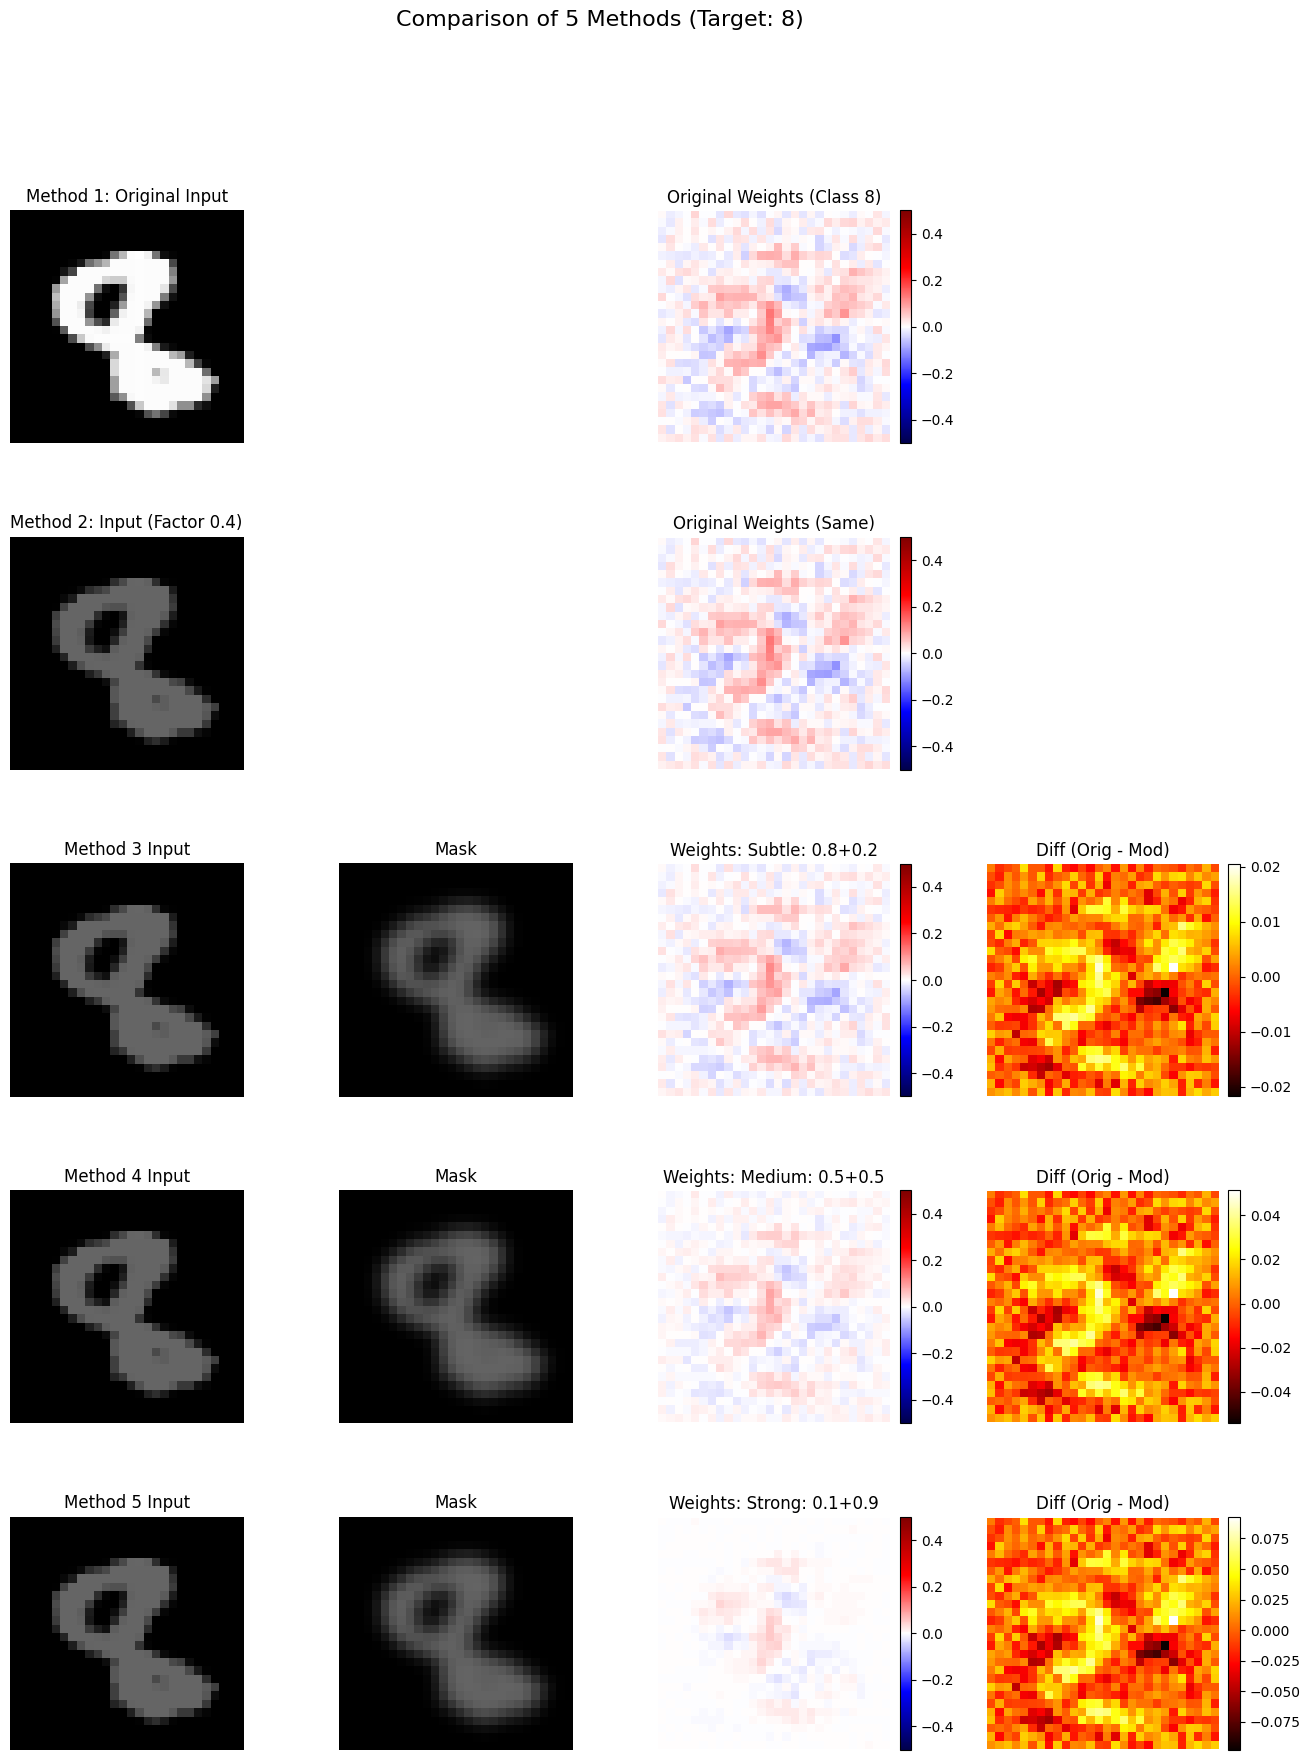

In [10]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

# --- User Adjustments ---
BRIGHTNESS_FACTOR = 0.4  # < 1.0 = Darker, > 1.0 = Lighter
BLUR_SIGMA = 1.0         # Extent of blur for the mask

# --- Constants ---
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

# --- Model Structure ---
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(784, 10)
    def forward(self, x):
        return self.fc(x.view(-1, 784))

# --- Data Loading ---
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# --- Load Model ---
model = SimpleNet()
try:
    model.load_state_dict(torch.load("mnist_simple_model.pth"))
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Error: 'mnist_simple_model.pth' not found. Please ensure the model file exists.")

model.eval()
weights_original = model.fc.weight.data.clone()
bias_original = model.fc.bias.data.clone()

# --- Helper Functions ---

def normalize_for_model(img_tensor):
    """Normalize [0,1] data to the range the model expects."""
    return (img_tensor - MNIST_MEAN) / MNIST_STD

def create_mask(img_tensor, sigma):
    """Create a blurred mask from the image (values 0 to 1)."""
    img_np = img_tensor.squeeze().numpy()
    blurred = scipy.ndimage.gaussian_filter(img_np, sigma=sigma)
    return np.clip(blurred, 0, 1)

def get_modified_weights(original_weights, mask, base_val, scale_val):
    """
    Modify weights based on mask brightness with customizable scaling.
    Formula: Factor = base_val + (scale_val * mask_pixel)

    Examples:
    - base=0.5, scale=0.5 -> Dark areas=0.5, Bright areas=1.0
    - base=0.1, scale=0.9 -> Dark areas=0.1, Bright areas=1.0
    """
    mask_flat = mask.flatten()
    # Calculate factor based on arguments
    mask_factor = base_val + (scale_val * mask_flat)

    mask_factor_tensor = torch.from_numpy(mask_factor).float()
    new_weights = original_weights * mask_factor_tensor
    return new_weights

# --- Evaluation Loop ---
correct_counts = [0, 0, 0, 0, 0] # Indices 0-4 for Methods 1-5
total = 0
sample_data = {}

# Define parameters for Methods 3, 4, 5
# Format: (Method Name, Base, Scale)
configs = [
    ("Method 3 (Subtle: 0.8+0.2)", 0.8, 0.2),
    ("Method 4 (Medium: 0.5+0.5)", 0.5, 0.5),
    ("Method 5 (Strong: 0.1+0.9)", 0.1, 0.9)
]

print(f"Running evaluation on {len(test_loader)} images...")

with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        target = target.item()

        # --- Method 1: Original Data ---
        input1 = normalize_for_model(data)
        out1 = model(input1)
        if out1.argmax(dim=1).item() == target: correct_counts[0] += 1

        # --- Method 2: Adjusted Brightness ---
        data_adj = torch.clamp(data * BRIGHTNESS_FACTOR, 0.0, 1.0)
        input2 = normalize_for_model(data_adj)
        out2 = model(input2)
        if out2.argmax(dim=1).item() == target: correct_counts[1] += 1

        # Generate mask once for methods 3, 4, 5
        mask_np = create_mask(data_adj, BLUR_SIGMA)
        x_flat = input2.view(-1, 784)

        # Loop through Methods 3, 4, 5
        current_weights = [] # Store for visualization

        for idx, (name, base, scale) in enumerate(configs):
            # Calculate specific weights for this method
            w_mod = get_modified_weights(weights_original, mask_np, base, scale)
            current_weights.append(w_mod)

            # Manual inference
            out_mod = torch.matmul(x_flat, w_mod.t()) + bias_original

            if out_mod.argmax(dim=1).item() == target:
                correct_counts[idx + 2] += 1

        # Capture first sample for visualization
        if i == 0:
            sample_data = {
                'input_orig': data.squeeze().numpy(),
                'input_adj': data_adj.squeeze().numpy(),
                'mask': mask_np,
                'w_orig': weights_original[target].reshape(28,28).numpy(),
                'w_mods': [w[target].reshape(28,28).numpy() for w in current_weights],
                'target': target
            }
        total += 1

# --- Results ---
accuracies = [100. * c / total for c in correct_counts]

print("-" * 50)
print(f"Method 1 (Original):                 {accuracies[0]:.2f}%")
print(f"Method 2 (Brightness x{BRIGHTNESS_FACTOR}):         {accuracies[1]:.2f}%")
print(f"Method 3 (Mask 0.8 + 0.2):           {accuracies[2]:.2f}%")
print(f"Method 4 (Mask 0.5 + 0.5):           {accuracies[3]:.2f}%")
print(f"Method 5 (Mask 0.1 + 0.9):           {accuracies[4]:.2f}%")
print("-" * 50)

# --- Visualization ---
# 5 Rows, 4 Columns
fig, axes = plt.subplots(5, 4, figsize=(16, 20))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Row 1: Method 1
axes[0,0].imshow(sample_data['input_orig'], cmap='gray', vmin=0, vmax=1)
axes[0,0].set_title("Method 1: Original Input")
axes[0,1].axis('off')
im1 = axes[0,2].imshow(sample_data['w_orig'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[0,2].set_title(f"Original Weights (Class {sample_data['target']})")
fig.colorbar(im1, ax=axes[0,2], fraction=0.046, pad=0.04)
axes[0,3].axis('off')

# Row 2: Method 2
axes[1,0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
axes[1,0].set_title(f"Method 2: Input (Factor {BRIGHTNESS_FACTOR})")
axes[1,1].axis('off')
im2 = axes[1,2].imshow(sample_data['w_orig'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[1,2].set_title("Original Weights (Same)")
fig.colorbar(im2, ax=axes[1,2], fraction=0.046, pad=0.04)
axes[1,3].axis('off')

# Rows 3, 4, 5: Methods 3, 4, 5
for i in range(3): # 0, 1, 2 correpsonding to Meth 3, 4, 5
    row_idx = i + 2
    axes[row_idx, 0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
    axes[row_idx, 0].set_title(f"Method {i+3} Input")

    axes[row_idx, 1].imshow(sample_data['mask'], cmap='gray', vmin=0, vmax=1)
    axes[row_idx, 1].set_title("Mask")

    w_mod_display = sample_data['w_mods'][i]
    im_mod = axes[row_idx, 2].imshow(w_mod_display, cmap='seismic', vmin=-0.5, vmax=0.5)
    config_name = configs[i][0].split('(')[1].strip(')') # Parse name for display
    axes[row_idx, 2].set_title(f"Weights: {config_name}")
    fig.colorbar(im_mod, ax=axes[row_idx, 2], fraction=0.046, pad=0.04)

    # Diff
    diff = sample_data['w_orig'] - w_mod_display
    im_diff = axes[row_idx, 3].imshow(diff, cmap='hot')
    axes[row_idx, 3].set_title("Diff (Orig - Mod)")
    fig.colorbar(im_diff, ax=axes[row_idx, 3], fraction=0.046, pad=0.04)

for ax in axes.flat:
    ax.axis('off')

plt.suptitle(f"Comparison of 5 Methods (Target: {sample_data['target']})", fontsize=16)
plt.show()

Model loaded successfully.
Running evaluation on 10000 images...
--------------------------------------------------
Method 1 (Original):                 91.91%
Method 2 (Brightness x0.4):         75.05%
Method 3 (Mask 0.8 + 0.2):           76.38%
Method 4 (Mask 0.5 + 0.5):           79.72%
Method 5 (Mask 0.1 + 0.9):           89.29%
--------------------------------------------------


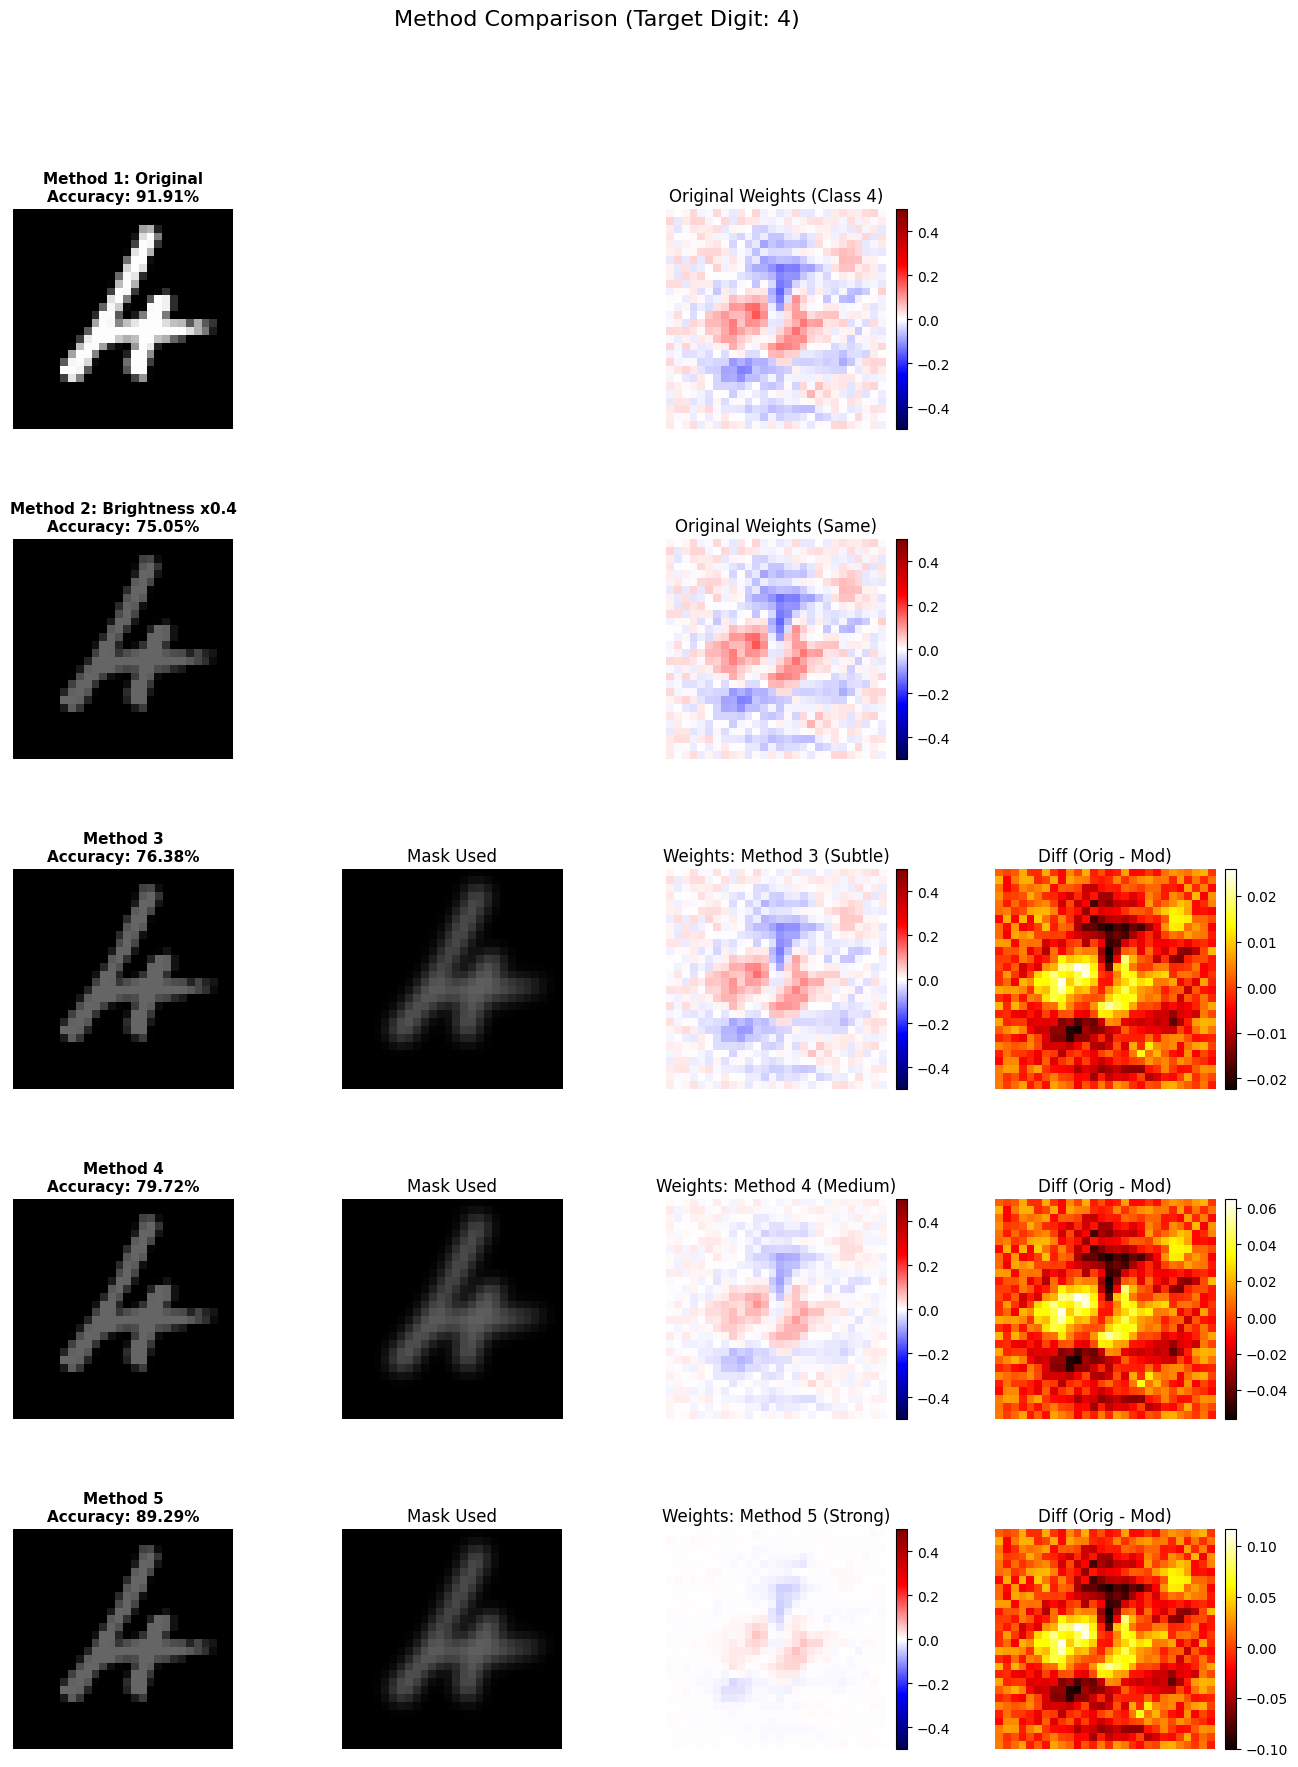

In [11]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

# --- User Adjustments ---
BRIGHTNESS_FACTOR = 0.4  # < 1.0 = Darker, > 1.0 = Lighter
BLUR_SIGMA = 1.0         # Extent of blur for the mask

# --- Constants ---
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

# --- Model Structure ---
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(784, 10)
    def forward(self, x):
        return self.fc(x.view(-1, 784))

# --- Data Loading ---
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# --- Load Model ---
model = SimpleNet()
try:
    model.load_state_dict(torch.load("mnist_simple_model.pth"))
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Error: 'mnist_simple_model.pth' not found. Please ensure the model file exists.")

model.eval()
weights_original = model.fc.weight.data.clone()
bias_original = model.fc.bias.data.clone()

# --- Helper Functions ---

def normalize_for_model(img_tensor):
    """Normalize [0,1] data to the range the model expects."""
    return (img_tensor - MNIST_MEAN) / MNIST_STD

def create_mask(img_tensor, sigma):
    """Create a blurred mask from the image (values 0 to 1)."""
    img_np = img_tensor.squeeze().numpy()
    blurred = scipy.ndimage.gaussian_filter(img_np, sigma=sigma)
    return np.clip(blurred, 0, 1)

def get_modified_weights(original_weights, mask, base_val, scale_val):
    """
    Modify weights based on mask brightness with customizable scaling.
    Formula: Factor = base_val + (scale_val * mask_pixel)
    """
    mask_flat = mask.flatten()
    mask_factor = base_val + (scale_val * mask_flat)
    mask_factor_tensor = torch.from_numpy(mask_factor).float()
    new_weights = original_weights * mask_factor_tensor
    return new_weights

# --- Evaluation Loop ---
correct_counts = [0, 0, 0, 0, 0] # Indices 0-4 for Methods 1-5
total = 0
sample_data = {}

# Define parameters for Methods 3, 4, 5
# Format: (Method Name, Base, Scale)
configs = [
    ("Method 3 (Subtle)", 0.8, 0.2),
    ("Method 4 (Medium)", 0.5, 0.5),
    ("Method 5 (Strong)", 0.1, 0.9)
]

print(f"Running evaluation on {len(test_loader)} images...")

with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        target = target.item()

        # --- Method 1: Original Data ---
        input1 = normalize_for_model(data)
        out1 = model(input1)
        if out1.argmax(dim=1).item() == target: correct_counts[0] += 1

        # --- Method 2: Adjusted Brightness ---
        data_adj = torch.clamp(data * BRIGHTNESS_FACTOR, 0.0, 1.0)
        input2 = normalize_for_model(data_adj)
        out2 = model(input2)
        if out2.argmax(dim=1).item() == target: correct_counts[1] += 1

        # Generate mask once for methods 3, 4, 5
        mask_np = create_mask(data_adj, BLUR_SIGMA)
        x_flat = input2.view(-1, 784)

        # Loop through Methods 3, 4, 5
        current_weights = [] # Store for visualization

        for idx, (name, base, scale) in enumerate(configs):
            w_mod = get_modified_weights(weights_original, mask_np, base, scale)
            current_weights.append(w_mod)

            # Manual inference
            out_mod = torch.matmul(x_flat, w_mod.t()) + bias_original

            if out_mod.argmax(dim=1).item() == target:
                correct_counts[idx + 2] += 1

        # Capture first sample for visualization
        if i == 0:
            sample_data = {
                'input_orig': data.squeeze().numpy(),
                'input_adj': data_adj.squeeze().numpy(),
                'mask': mask_np,
                'w_orig': weights_original[target].reshape(28,28).numpy(),
                'w_mods': [w[target].reshape(28,28).numpy() for w in current_weights],
                'target': target
            }
        total += 1

# --- Results ---
accuracies = [100. * c / total for c in correct_counts]

print("-" * 50)
print(f"Method 1 (Original):                 {accuracies[0]:.2f}%")
print(f"Method 2 (Brightness x{BRIGHTNESS_FACTOR}):         {accuracies[1]:.2f}%")
print(f"Method 3 (Mask 0.8 + 0.2):           {accuracies[2]:.2f}%")
print(f"Method 4 (Mask 0.5 + 0.5):           {accuracies[3]:.2f}%")
print(f"Method 5 (Mask 0.1 + 0.9):           {accuracies[4]:.2f}%")
print("-" * 50)

# --- Visualization ---
# 5 Rows, 4 Columns
fig, axes = plt.subplots(5, 4, figsize=(16, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Row 1: Method 1
axes[0,0].imshow(sample_data['input_orig'], cmap='gray', vmin=0, vmax=1)
axes[0,0].set_title(f"Method 1: Original\nAccuracy: {accuracies[0]:.2f}%", fontsize=11, fontweight='bold')
axes[0,1].axis('off')
im1 = axes[0,2].imshow(sample_data['w_orig'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[0,2].set_title(f"Original Weights (Class {sample_data['target']})")
fig.colorbar(im1, ax=axes[0,2], fraction=0.046, pad=0.04)
axes[0,3].axis('off')

# Row 2: Method 2
axes[1,0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
axes[1,0].set_title(f"Method 2: Brightness x{BRIGHTNESS_FACTOR}\nAccuracy: {accuracies[1]:.2f}%", fontsize=11, fontweight='bold')
axes[1,1].axis('off')
im2 = axes[1,2].imshow(sample_data['w_orig'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[1,2].set_title("Original Weights (Same)")
fig.colorbar(im2, ax=axes[1,2], fraction=0.046, pad=0.04)
axes[1,3].axis('off')

# Rows 3, 4, 5: Methods 3, 4, 5
for i in range(3): # 0, 1, 2 correpsonding to Meth 3, 4, 5
    row_idx = i + 2
    method_acc = accuracies[row_idx]

    axes[row_idx, 0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
    axes[row_idx, 0].set_title(f"Method {i+3}\nAccuracy: {method_acc:.2f}%", fontsize=11, fontweight='bold')

    axes[row_idx, 1].imshow(sample_data['mask'], cmap='gray', vmin=0, vmax=1)
    axes[row_idx, 1].set_title("Mask Used")

    w_mod_display = sample_data['w_mods'][i]
    im_mod = axes[row_idx, 2].imshow(w_mod_display, cmap='seismic', vmin=-0.5, vmax=0.5)
    config_name = configs[i][0]
    axes[row_idx, 2].set_title(f"Weights: {config_name}")
    fig.colorbar(im_mod, ax=axes[row_idx, 2], fraction=0.046, pad=0.04)

    # Diff
    diff = sample_data['w_orig'] - w_mod_display
    im_diff = axes[row_idx, 3].imshow(diff, cmap='hot')
    axes[row_idx, 3].set_title("Diff (Orig - Mod)")
    fig.colorbar(im_diff, ax=axes[row_idx, 3], fraction=0.046, pad=0.04)

for ax in axes.flat:
    ax.axis('off')

plt.suptitle(f"Method Comparison (Target Digit: {sample_data['target']})", fontsize=16)
plt.show()

Model loaded successfully.
Running evaluation on 10000 images...
--------------------------------------------------
Method 1 (Original):                 91.91%
Method 2 (Brightness x0.4):         75.05%
Method 3 (Mask 0.8 + 0.2):           76.38%
Method 4 (Mask 0.5 + 0.5):           79.72%
Method 5 (Mask 0.1 + 0.9):           89.29%
--------------------------------------------------


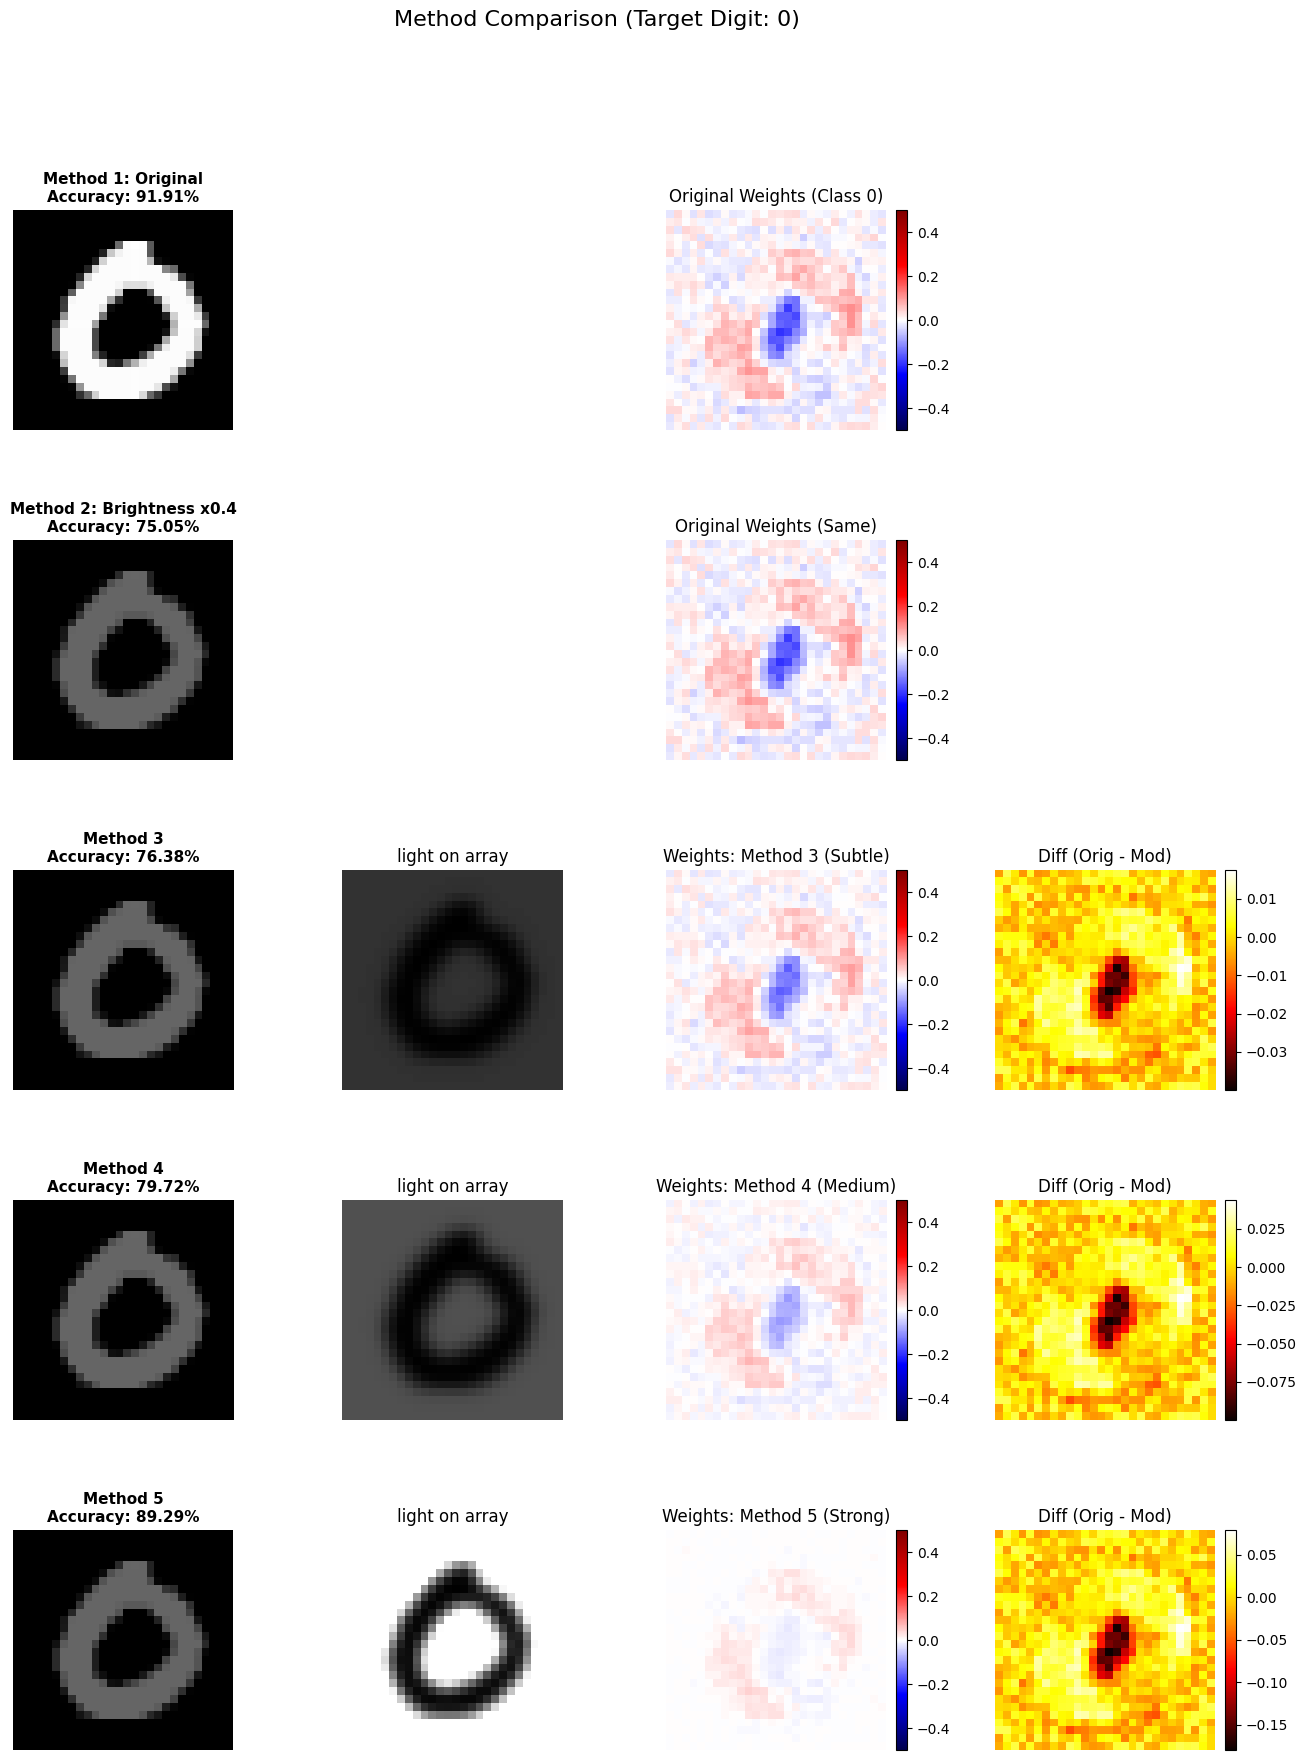

In [20]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage

# --- User Adjustments ---
BRIGHTNESS_FACTOR = 0.4  # < 1.0 = Darker, > 1.0 = Lighter
BLUR_SIGMA = 1.0         # Extent of blur for the mask

# --- Constants ---
MNIST_MEAN = 0.1307
MNIST_STD = 0.3081

# --- Model Structure ---
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc = nn.Linear(784, 10)
    def forward(self, x):
        return self.fc(x.view(-1, 784))

# --- Data Loading ---
transform = transforms.Compose([transforms.ToTensor()])
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=True)

# --- Load Model ---
model = SimpleNet()
try:
    model.load_state_dict(torch.load("mnist_simple_model.pth"))
    print("Model loaded successfully.")
except FileNotFoundError:
    print("Error: 'mnist_simple_model.pth' not found. Please ensure the model file exists.")

model.eval()
weights_original = model.fc.weight.data.clone()
bias_original = model.fc.bias.data.clone()

# --- Helper Functions ---

def normalize_for_model(img_tensor):
    """Normalize [0,1] data to the range the model expects."""
    return (img_tensor - MNIST_MEAN) / MNIST_STD

def create_mask(img_tensor, sigma):
    """Create a blurred mask from the image (values 0 to 1)."""
    img_np = img_tensor.squeeze().numpy()
    blurred = scipy.ndimage.gaussian_filter(img_np, sigma=sigma)
    return np.clip(blurred, 0, 1)

def get_modified_weights(original_weights, mask, base_val, scale_val):
    """
    Modify weights based on mask brightness with customizable scaling.
    Formula: Factor = base_val + (scale_val * mask_pixel)
    """
    mask_flat = mask.flatten()
    mask_factor = base_val + (scale_val * mask_flat)
    mask_factor_tensor = torch.from_numpy(mask_factor).float()
    new_weights = original_weights * mask_factor_tensor
    return new_weights

# --- Evaluation Loop ---
correct_counts = [0, 0, 0, 0, 0] # Indices 0-4 for Methods 1-5
total = 0
sample_data = {}

# Define parameters for Methods 3, 4, 5
# Format: (Method Name, Base, Scale)
configs = [
    ("Method 3 (Subtle)", 0.8, 0.2),
    ("Method 4 (Medium)", 0.5, 0.5),
    ("Method 5 (Strong)", 0.1, 0.9)
]

print(f"Running evaluation on {len(test_loader)} images...")

with torch.no_grad():
    for i, (data, target) in enumerate(test_loader):
        target = target.item()

        # --- Method 1: Original Data ---
        input1 = normalize_for_model(data)
        out1 = model(input1)
        if out1.argmax(dim=1).item() == target: correct_counts[0] += 1

        # --- Method 2: Adjusted Brightness ---
        data_adj = torch.clamp(data * BRIGHTNESS_FACTOR, 0.0, 1.0)
        input2 = normalize_for_model(data_adj)
        out2 = model(input2)
        if out2.argmax(dim=1).item() == target: correct_counts[1] += 1

        # Generate mask once for methods 3, 4, 5
        mask_np = create_mask(data_adj, BLUR_SIGMA)
        x_flat = input2.view(-1, 784)

        # Loop through Methods 3, 4, 5
        current_weights = [] # Store for visualization

        for idx, (name, base, scale) in enumerate(configs):
            w_mod = get_modified_weights(weights_original, mask_np, base, scale)
            current_weights.append(w_mod)

            # Manual inference
            out_mod = torch.matmul(x_flat, w_mod.t()) + bias_original

            if out_mod.argmax(dim=1).item() == target:
                correct_counts[idx + 2] += 1

        # Capture first sample for visualization
        if i == 0:
            sample_data = {
                'input_orig': data.squeeze().numpy(),
                'input_adj': data_adj.squeeze().numpy(),
                'mask': mask_np,
                'w_orig': weights_original[target].reshape(28,28).numpy(),
                'w_mods': [w[target].reshape(28,28).numpy() for w in current_weights],
                'target': target
            }
        total += 1

# --- Results ---
accuracies = [100. * c / total for c in correct_counts]

print("-" * 50)
print(f"Method 1 (Original):                 {accuracies[0]:.2f}%")
print(f"Method 2 (Brightness x{BRIGHTNESS_FACTOR}):         {accuracies[1]:.2f}%")
print(f"Method 3 (Mask 0.8 + 0.2):           {accuracies[2]:.2f}%")
print(f"Method 4 (Mask 0.5 + 0.5):           {accuracies[3]:.2f}%")
print(f"Method 5 (Mask 0.1 + 0.9):           {accuracies[4]:.2f}%")
print("-" * 50)

# --- Visualization ---
# 5 Rows, 4 Columns
fig, axes = plt.subplots(5, 4, figsize=(16, 20))
plt.subplots_adjust(hspace=0.5, wspace=0.3)

# Row 1: Method 1
axes[0,0].imshow(sample_data['input_orig'], cmap='gray', vmin=0, vmax=1)
axes[0,0].set_title(f"Method 1: Original\nAccuracy: {accuracies[0]:.2f}%", fontsize=11, fontweight='bold')
axes[0,1].axis('off')
im1 = axes[0,2].imshow(sample_data['w_orig'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[0,2].set_title(f"Original Weights (Class {sample_data['target']})")
fig.colorbar(im1, ax=axes[0,2], fraction=0.046, pad=0.04)
axes[0,3].axis('off')

# Row 2: Method 2
axes[1,0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
axes[1,0].set_title(f"Method 2: Brightness x{BRIGHTNESS_FACTOR}\nAccuracy: {accuracies[1]:.2f}%", fontsize=11, fontweight='bold')
axes[1,1].axis('off')
im2 = axes[1,2].imshow(sample_data['w_orig'], cmap='seismic', vmin=-0.5, vmax=0.5)
axes[1,2].set_title("Original Weights (Same)")
fig.colorbar(im2, ax=axes[1,2], fraction=0.046, pad=0.04)
axes[1,3].axis('off')

# Rows 3, 4, 5: Methods 3, 4, 5
for i in range(3): # 0, 1, 2 correpsonding to Meth 3, 4, 5
    row_idx = i + 2
    method_acc = accuracies[row_idx]

    # Retrieve base factor
    base_factor = configs[i][1]

    axes[row_idx, 0].imshow(sample_data['input_adj'], cmap='gray', vmin=0, vmax=1)
    axes[row_idx, 0].set_title(f"Method {i+3}\nAccuracy: {method_acc:.2f}%", fontsize=11, fontweight='bold')

    # --- MODIFIED SECTION ---
    # 1. Invert
    mask_display = 1.0 - sample_data['mask']*BRIGHTNESS_FACTOR/base_factor

    # 2. Subtract min so floor is 0
    mask_display = mask_display - mask_display.min()


    axes[row_idx, 1].imshow(mask_display, cmap='gray', vmin=0, vmax=1)
    axes[row_idx, 1].set_title("light on array")
    # ------------------------

    w_mod_display = sample_data['w_mods'][i]
    im_mod = axes[row_idx, 2].imshow(w_mod_display, cmap='seismic', vmin=-0.5, vmax=0.5)
    config_name = configs[i][0]
    axes[row_idx, 2].set_title(f"Weights: {config_name}")
    fig.colorbar(im_mod, ax=axes[row_idx, 2], fraction=0.046, pad=0.04)

    # Diff
    diff = sample_data['w_orig'] - w_mod_display
    im_diff = axes[row_idx, 3].imshow(diff, cmap='hot')
    axes[row_idx, 3].set_title("Diff (Orig - Mod)")
    fig.colorbar(im_diff, ax=axes[row_idx, 3], fraction=0.046, pad=0.04)

for ax in axes.flat:
    ax.axis('off')

plt.suptitle(f"Method Comparison (Target Digit: {sample_data['target']})", fontsize=16)
plt.show()